In [78]:
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
from tqdm import tqdm

In [79]:
# Constants
INPUT_FILE = "../2feature_extraction/jobs.csv"
OUTPUT_FILE = "cleaned_jobs.csv"
PROFILE_OUTPUT = "jobs_profile_report.html"

FREQUENCY_THRESHOLD = 1  # 0-100 probability slider for removal
SGD_TO_USD = 0.74
# More precise representation of the conversion rate
RUP_TO_USD = 12 / 1000  # This ensures we keep precision
MIN_RATE_PER_HOUR_RUP = 100
MAX_RATE_PER_HOUR_RUP = 10000  # Maximum reasonable hourly rate in rupees

In [80]:
# Read the data
df = pd.read_csv(INPUT_FILE)


# Remove unnecessary columns
columns_to_drop = [
    "job_id",  # Internal identifier not needed
    "job_link",  # URL not needed for analysis
    "index",  # If exists
    "Unnamed: 0",  # If exists
]

df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

In [81]:
# Clean and process the data
def clean_skills_list(skills_str):
    if pd.isna(skills_str) or skills_str == "":
        return []
    # Replace both spaces and underscores with hyphens within each skill
    return [
        skill.strip().lower().replace(" ", "-").replace("_", "-")
        for skill in skills_str.split(",")
    ]

# Process skills columns
df["soft_skills"] = df["soft_skills"].apply(clean_skills_list)
df["hard_skills"] = df["hard_skills"].apply(clean_skills_list)
df["field_of_study"] = df["field_of_study"].apply(clean_skills_list)

In [82]:
# First handle the experience values
# Replace -1 with NaN using numpy
df["min_years_experience"] = np.where(df["min_years_experience"] == -1, np.nan, df["min_years_experience"])

print(f"\nEmpty experience values before imputation: {df['min_years_experience'].isna().sum()}")
df["min_years_experience"] = df["min_years_experience"].fillna(0.0)
print(f"Empty experience values after imputation: {df['min_years_experience'].isna().sum()}")


Empty experience values before imputation: 10810
Empty experience values after imputation: 0


In [83]:
# Then handle categorical columns using a more direct approach
categorical_columns = ["location_flexibility", "contract_type", "education_level", "seniority"]
for col in categorical_columns:
    df[col] = df[col].replace({"unspecified": pd.NA})

In [84]:
# Analyze and clean low-frequency values
categorical_cols = [
    "location_flexibility",
    "contract_type",
    "education_level",
    "seniority",
    "salary_period",
    # "soft_skills",
    # "hard_skills",
    # "field_of_study",
]

print("\nLeast frequent values in categorical columns:")
for col in categorical_cols:
    value_counts = df[col].value_counts(normalize=True) * 100
    print(f"\n{col.replace('_', ' ').title()}:")
    print(value_counts.nsmallest(6).round(2).to_string())

print(
    f"\nReplacing values that occur less than {FREQUENCY_THRESHOLD}% of the time with NA..."
)

# Store original counts
original_counts = {col: df[col].notna().sum() for col in categorical_cols}

# Replace low-frequency values with NA
for col in categorical_cols:
    value_counts = df[col].value_counts(normalize=True) * 100
    low_freq_values = value_counts[value_counts < FREQUENCY_THRESHOLD].index
    df[col] = df[col].replace(dict.fromkeys(low_freq_values, pd.NA))

# Print removal report
print("\nRemoval Report:")
for col in categorical_cols:
    removed = original_counts[col] - df[col].notna().sum()
    if removed > 0:
        print(f"{col.replace('_', ' ').title()}: {removed} values replaced with NA")


Least frequent values in categorical columns:

Location Flexibility:
location_flexibility
remote    11.04
hybrid    11.06
onsite    77.90

Contract Type:
contract_type
trainee                                                  0.00
temporary                                                0.00
['full-time', 'part-time', 'internship', 'freelance']    0.00
['full-time', 'internship']                              0.00
freelance                                                0.00
internship                                               0.88

Education Level:
education_level
certificate     0.00
associates      0.03
diploma         0.04
phd             2.85
high_school     7.83
masters        10.17

Seniority:
seniority
junior-senior     0.00
professional      0.01
entry-level       0.01
junior           27.83
senior           32.65
mid-level        39.50

Salary Period:
salary_period
unspecified     0.00
per_course      0.00
hourly         11.03
monthly        28.57
yearly         60.40

Rep

In [64]:
# Print some basic statistics
print("\nDataset Summary:")
print(f"Total number of jobs: {len(df)}")
print(f"Number of columns: {len(df.columns)}")
print("\nMissing values:")
print(df.isna().sum())

# Analyze salary_period NA values
print("\nSalary Period Analysis:")
print(f"Total NA values in salary_period: {df['salary_period'].isna().sum()}")
print("\nSample of rows with NA salary_period:")
print(df[df["salary_period"].isna()].head())

# Analyze specific cases
print("\nAnalyzing specific salary cases with missing periods:")
print("\nREMOVAL NOTICE:")
print("The Astronomer (Adjunct Faculty) position will be removed because:")
print("- The salary ($1,700 - $3,000) is likely per-course based")
print("- Per-course compensation cannot be standardized with other salary periods")
print("- This ensures consistency in salary comparisons across the dataset")

# Remove the specific astronomer row by index
df = df[df.index != 9737]
print(
    "\nRemoved row with index 9737 (Astronomer position with per-course salary structure)"
)

print("\nSalary Period Analysis for University Lecturer case:")
print("Salary Range: $7,500 - $8,000")
print("Likely Period: MONTHLY")
print("Reasoning:")
print("- Part-time lecturer positions typically quote monthly salaries")
print("- The range is too low for yearly academic salary")
print("- Too high for hourly or weekly compensation")
print("- Consistent with typical monthly lecturer compensation")

# Manually set the salary period for the University Lecturer case
df.loc[27675, "salary_period"] = "monthly"
print("\nUpdated salary period for University Lecturer (index 27675) to monthly")\

# Convert salaries to USD based on country
print("\nConverting salaries to USD...")

# Create USD columns
df["min_salary_usd"] = df["min_salary"]
df["max_salary_usd"] = df["max_salary"]

# Convert Singapore salaries (SGD to USD)
sg_mask = df["country"] == "SG"
df.loc[sg_mask, "min_salary_usd"] = df.loc[sg_mask, "min_salary"] * SGD_TO_USD
df.loc[sg_mask, "max_salary_usd"] = df.loc[sg_mask, "max_salary"] * SGD_TO_USD


Dataset Summary:
Total number of jobs: 41515
Number of columns: 17

Missing values:
query                       0
country                     0
job_description             0
location                    6
salary                      0
job_title                   3
soft_skills                 0
hard_skills                 0
location_flexibility     1008
contract_type             976
education_level         10596
field_of_study              0
seniority                6131
min_years_experience        0
min_salary                  0
max_salary                  0
salary_period               2
dtype: int64

Salary Period Analysis:
Total NA values in salary_period: 2

Sample of rows with NA salary_period:
                     query country  \
9737            astronomer      US   
27675  university lecturer      US   

                                         job_description           location  \
9737   Title: Adjunct Faculty - Astronomy (online)\nS...  Bowling Green, KY   
27675  University o

In [ ]:
df.loc[9763, "]

<Axes: xlabel='min_salary_usd', ylabel='Count'>

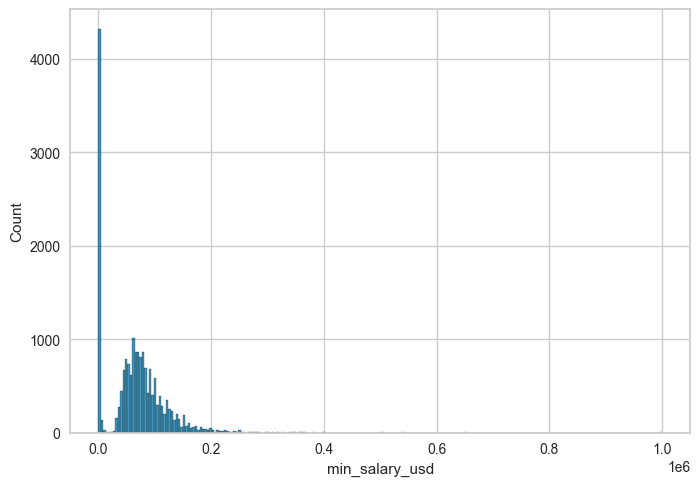

In [65]:
import seaborn as sns
sns.histplot(data=df[df["country"] == "US"], x="min_salary_usd")

<Axes: xlabel='min_salary_usd', ylabel='Count'>

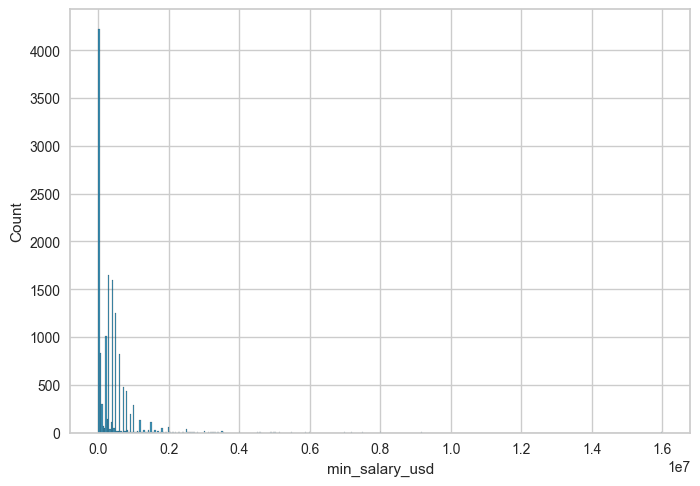

In [66]:
sns.histplot(data=df[df["country"] == "IN"], x="min_salary_usd")

<Axes: xlabel='min_salary_usd', ylabel='Count'>

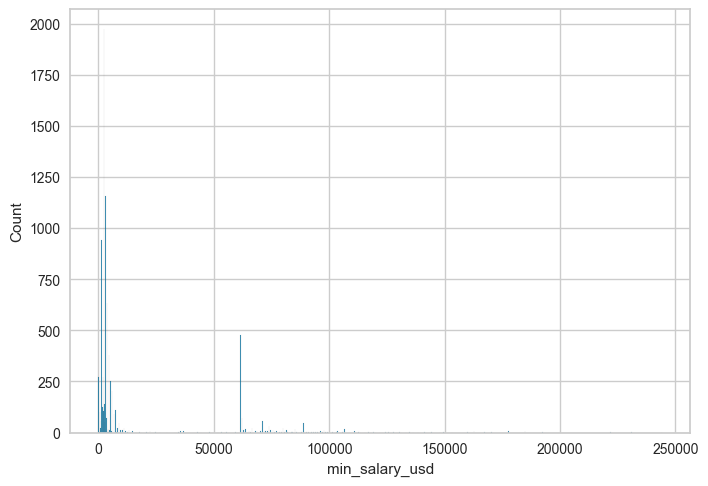

In [67]:
sns.histplot(data=df[df["country"] == "SG"], x="min_salary_usd")

In [68]:
df[df["country"] =="IN"].sort_values("max_salary", ascending=False)[["salary", "min_salary", "max_salary"]]

,salary,min_salary,max_salary
25234,₹16T - ₹18T (Employer Est.),16000000.0,18000000.0
30594,₹75L - ₹99L (Employer Est.),7500000.0,9900000.0
3002,₹92L (Employer Est.),9150000.0,9150000.0
29203,₹75L - ₹90L (Employer Est.),7500000.0,9000000.0
2249,₹60L - ₹85L (Employer Est.),6000000.0,8500000.0
...,...,...,...
20299,₹22T (Employer Est.),22000.0,-1.0
5141,₹10T (Employer Est.),10000.0,-1.0
17879,₹60T (Employer Est.),60000.0,-1.0
25293,₹20T (Employer Est.),20000.0,-1.0


The model is not good at identifying the correct salary for Indian rupees. Therefore, we need to manually determine them.

In [69]:
# Define salary thresholds for different periods
SALARY_THRESHOLDS = {
    "hourly": {
        "min": 0,  # No minimum for hourly rate
        "max": 500,  # $500/hour maximum
    },
    "monthly": {
        "min": 500,  # $500/month minimum
        "max": 50_000,  # $50000/month maximum
    },
    "yearly": {
        "min": 6000,  # $6000/year minimum
        "max": 3_000_000,  # $3 mill/year maximum
    },
}

In [70]:
# Function to parse Indian salary format
def parse_indian_salary(salary_text):
    if pd.isna(salary_text):
        return None, None, None

    import re

    # Pattern to match Indian salary format with commas, decimals, and period
    pattern = r"₹\s*([\d,]+(?:\.\d{1,2})?)\s*([LKT])?(?:\s*-\s*₹\s*([\d,]+(?:\.\d{1,2})?)\s*([LKT])?)?(?:\s*(?:Per|per)\s*(?:hour|month|year|annum))?"

    match = re.search(pattern, salary_text)
    if not match:
        return None, None, None

    min_val, min_unit, max_val, max_unit = match.groups()

    def convert_to_rupees(value, unit):
        if value is None:
            return None
        # Remove commas and convert to float
        value = float(value.replace(",", ""))
        if unit == "L":  # Lakh = 100,000
            return value * 100000
        elif unit in ["K", "T"]:  # Both K and T represent Thousand = 1,000
            return value * 1000
        return value

    min_salary = convert_to_rupees(min_val, min_unit)
    max_salary = convert_to_rupees(max_val, max_unit) if max_val else min_salary

    # Default to None for period, will be determined in parse_with_description
    period = None
    return min_salary, max_salary, period


# Process Indian salaries
print("\nProcessing Indian Rupee salaries...")
in_mask = df["country"] == "IN"
indian_salaries = df[in_mask].copy()


# Modified parse_indian_salary to accept job description
def parse_with_description(row):
    min_salary, max_salary, period = parse_indian_salary(row["salary"])

    # If we got valid salaries, check both salary and description for period hints
    if min_salary is not None:
        # Check job description for period indicators
        desc_lower = str(row["job_description"]).lower()
        salary_lower = str(row["salary"]).lower()

        # Combine both texts for checking
        combined_text = f"{desc_lower} {salary_lower}"

        # Convert amount to USD for threshold checking
        amount_usd = max_salary * RUP_TO_USD

        # Allow explicit mentions in text to override the threshold-based detection
        desc_lower = str(row["job_description"]).lower()
        salary_lower = str(row["salary"]).lower()
        combined_text = f"{desc_lower} {salary_lower}"
        
        # Use simple thresholds to determine period
        if amount_usd <= 10:
            period = "hourly"
        elif amount_usd <= 2400:
            period = "monthly"
            if "per year" in combined_text:
                period = "yearly"
        else:
            period = "yearly"

    return min_salary, max_salary, period


# Parse each Indian salary with job description context
parsed_salaries = indian_salaries.apply(parse_with_description, axis=1)
indian_salaries["min_salary"] = parsed_salaries.apply(lambda x: x[0])
indian_salaries["max_salary"] = parsed_salaries.apply(lambda x: x[1])
indian_salaries["salary_period"] = parsed_salaries.apply(lambda x: x[2])


# Convert to USD directly without period consideration
def convert_to_usd(value):
    if pd.isna(value):
        return None
    return value * RUP_TO_USD


indian_salaries["min_salary_usd"] = indian_salaries["min_salary"].apply(convert_to_usd)
indian_salaries["max_salary_usd"] = indian_salaries["max_salary"].apply(convert_to_usd)

# Update the main dataframe with explicit assignment
df.loc[in_mask, "min_salary_usd"] = indian_salaries["min_salary_usd"]
df.loc[in_mask, "max_salary_usd"] = indian_salaries["max_salary_usd"]
df.loc[in_mask, "salary_period"] = indian_salaries["salary_period"]


Processing Indian Rupee salaries...


In [71]:
indian_salaries[["job_description", "salary", "min_salary", "max_salary", "min_salary_usd", "max_salary_usd", "salary_period"]].sort_values("max_salary", ascending=False).to_csv("indian_salaries.csv")

In [72]:
# Debug specific indexes
debug_indexes = [178, 401, 767]
print("\nDebugging specific salary conversions:")
for idx in debug_indexes:
    row = df.loc[idx]
    print(f"\nIndex {idx}:")
    print(f"Country: {row['country']}")
    print(f"Original salary text: {row['salary']}")
    print(f"min_salary (original): {row['min_salary']}")
    print(f"max_salary (original): {row['max_salary']}")
    print(f"min_salary_usd: {row['min_salary_usd']}")
    print(f"max_salary_usd: {row['max_salary_usd']}")
    if row["country"] == "IN":
        print(f"Conversion calculation:")
        print(
            f"min: ({row['min_salary']} * 12) / 1000 = {(row['min_salary'] * 12) / 1000}"
        )
        print(
            f"max: ({row['max_salary']} * 12) / 1000 = {(row['max_salary'] * 12) / 1000}"
        )
    elif row["country"] == "SG":
        print(f"Conversion calculation:")
        print(
            f"min: {row['min_salary']} * {SGD_TO_USD} = {row['min_salary'] * SGD_TO_USD}"
        )
        print(
            f"max: {row['max_salary']} * {SGD_TO_USD} = {row['max_salary'] * SGD_TO_USD}"
        )

# Print summary of changes
print("\nSample of parsed Indian salaries:")
sample_size = min(5, len(indian_salaries))
for _, row in indian_salaries.sample(sample_size).iterrows():
    print(f"\nOriginal: {row['salary']}")
    print(
        f"Parsed: ₹{row['min_salary']:,.2f} - ₹{row['max_salary']:,.2f} ({row['salary_period']})"
    )
    print(f"In USD: ${row['min_salary_usd']:,.2f} - ${row['max_salary_usd']:,.2f}")

print(f"Converted {sg_mask.sum()} Singapore salaries from SGD to USD")
print(f"Converted {in_mask.sum()} India salaries from Rupee to USD")

def validate_and_correct_salary_period(row):
    """
    Validates and corrects salary period based on salary ranges in USD.
    Returns the most likely salary period.
    """
    min_salary = row["min_salary_usd"]
    max_salary = row["max_salary_usd"]
    current_period = row["salary_period"]

    # Use the higher salary for validation to catch edge cases
    test_salary = max(min_salary, max_salary) if max_salary > 0 else min_salary

    # Skip if salary is invalid
    if test_salary <= 0:
        return current_period

    # Check if current period is valid
    if pd.notna(current_period):
        thresh = SALARY_THRESHOLDS.get(current_period)
        if thresh and thresh["min"] <= test_salary <= thresh["max"]:
            return current_period

    # Try to determine the correct period
    for period, thresh in SALARY_THRESHOLDS.items():
        if thresh["min"] <= test_salary <= thresh["max"]:
            return period

    # If no period matches, use yearly as default for outliers
    return "yearly"


# Validate and correct salary periods only for US and Singapore
print("\nValidating and correcting salary periods for US and Singapore...")
original_periods = df["salary_period"].copy()
us_sg_mask = df["country"].isin(["US", "SG"])
df.loc[us_sg_mask, "salary_period"] = df[us_sg_mask].apply(
    validate_and_correct_salary_period, axis=1
)

# Define conversion multipliers
HOURS_PER_YEAR = 2080  # 40 hours/week * 52 weeks
MONTHS_PER_YEAR = 12

# Create columns for standardized salaries in USD
df["yearly_min_salary"] = df["min_salary_usd"]
df["yearly_max_salary"] = df["max_salary_usd"]

# Convert hourly salaries to yearly
hourly_mask = df["salary_period"] == "hourly"
df.loc[hourly_mask, "yearly_min_salary"] = (
    df.loc[hourly_mask, "min_salary_usd"] * HOURS_PER_YEAR
)
df.loc[hourly_mask, "yearly_max_salary"] = (
    df.loc[hourly_mask, "max_salary_usd"] * HOURS_PER_YEAR
)

# Convert monthly salaries to yearly
monthly_mask = df["salary_period"] == "monthly"
df.loc[monthly_mask, "yearly_min_salary"] = (
    df.loc[monthly_mask, "min_salary_usd"] * MONTHS_PER_YEAR
)
df.loc[monthly_mask, "yearly_max_salary"] = (
    df.loc[monthly_mask, "max_salary_usd"] * MONTHS_PER_YEAR
)


Debugging specific salary conversions:

Index 178:
Country: IN
Original salary text: ₹1,000.00 Per hour (Employer Est.)
min_salary (original): 1000.0
max_salary (original): 1000.0
min_salary_usd: 12.0
max_salary_usd: 12.0
Conversion calculation:
min: (1000.0 * 12) / 1000 = 12.0
max: (1000.0 * 12) / 1000 = 12.0

Index 401:
Country: IN
Original salary text: ₹2,000.00 - ₹2,500.00 Per hour (Employer Est.)
min_salary (original): 2000.0
max_salary (original): 2500.0
min_salary_usd: 24.0
max_salary_usd: 30.0
Conversion calculation:
min: (2000.0 * 12) / 1000 = 24.0
max: (2500.0 * 12) / 1000 = 30.0

Index 767:
Country: IN
Original salary text: ₹1,200.00 Per hour (Employer Est.)
min_salary (original): 1200.0
max_salary (original): 1200.0
min_salary_usd: 14.4
max_salary_usd: 14.4
Conversion calculation:
min: (1200.0 * 12) / 1000 = 14.4
max: (1200.0 * 12) / 1000 = 14.4

Sample of parsed Indian salaries:

Original: ₹11T - ₹15T (Employer Est.)
Parsed: ₹11,000.00 - ₹15,000.00 (monthly)
In USD: $132.

In [73]:
# Calculate salary midpoints
print("\nCalculating salary midpoints...")

# Initialize midpoint column
df["yearly_salary_midpoint"] = pd.NA

# Calculate midpoints for rows where both min and max are valid
valid_range_mask = (df["yearly_min_salary"] >= 0) & (df["yearly_max_salary"] >= 0)
df.loc[valid_range_mask, "yearly_salary_midpoint"] = df.loc[
    valid_range_mask, ["yearly_min_salary", "yearly_max_salary"]
].mean(axis=1)

# For rows where only one value is valid, use that value
min_only_mask = (df["yearly_min_salary"] >= 0) & (df["yearly_max_salary"] < 0)
df.loc[min_only_mask, "yearly_salary_midpoint"] = df.loc[
    min_only_mask, "yearly_min_salary"
]

max_only_mask = (df["yearly_max_salary"] >= 0) & (df["yearly_min_salary"] < 0)
df.loc[max_only_mask, "yearly_salary_midpoint"] = df.loc[
    max_only_mask, "yearly_max_salary"
]

# Set manual thresholds
print("\nApplying manual salary thresholds...")
SALARY_LOW_THRESHOLD = 1000  # $1000 per year
SALARY_LOW_THRESHOLD_DISPLAY = "1K"
SALARY_HIGH_THRESHOLD = 1000000  # $2 million per year
SALARY_HIGH_THRESHOLD_DISPLAY = "1M"

# Identify extreme cases based on manual thresholds
extreme_salaries = df[
    (df["yearly_salary_midpoint"] >= SALARY_HIGH_THRESHOLD)
    | (df["yearly_salary_midpoint"] <= SALARY_LOW_THRESHOLD)
]
# Add a column to identify if it's high or low
extreme_salaries["salary_category"] = "NORMAL"
extreme_salaries.loc[
    extreme_salaries["yearly_salary_midpoint"] >= SALARY_HIGH_THRESHOLD,
    "salary_category",
] = f"HIGH (Above ${SALARY_HIGH_THRESHOLD_DISPLAY}/year)"
extreme_salaries.loc[
    extreme_salaries["yearly_salary_midpoint"] <= SALARY_LOW_THRESHOLD,
    "salary_category",
] = f"LOW (Below ${SALARY_LOW_THRESHOLD_DISPLAY}/year)"

extreme_salaries.to_csv("extreme_salaries.csv", index=True)
print(f"Exported {len(extreme_salaries)} extreme salary cases to extreme_salaries.csv")


Calculating salary midpoints...

Applying manual salary thresholds...
Exported 129 extreme salary cases to extreme_salaries.csv


In [74]:
df.sort_values("yearly_salary_midpoint", ascending=False)

,query,country,job_description,location,salary,job_title,soft_skills,hard_skills,location_flexibility,contract_type,...,seniority,min_years_experience,min_salary,max_salary,salary_period,min_salary_usd,max_salary_usd,yearly_min_salary,yearly_max_salary,yearly_salary_midpoint
9763,mathematician,US,"Chicago $650,000 - $3,000,000 Permanent\nJoin ...","Chicago, IL",US$113K - US$183K (Glassdoor Est.),Quantitative Researcher,"[problem-solving, collaboration, innovation, a...","[machine-learning, data-science, c++, python, ...",onsite,full-time,...,senior,3.0,650000.0,3000000.00,yearly,650000.0000,3.000000e+06,650000.0000,3.000000e+06,1825000.0
5930,physical therapist,US,Job Description\nPRN (Shifts Vary)\nGRMC disti...,"Seguin, TX",US$1M (Employer Est.),PHYSICAL THERAPIST - INPATIENT REHAB PRN,"[communication, problem-solving, compassion]","[physical-therapy-treatment, patient-evaluatio...",onsite,part-time,...,<NA>,1.0,1000000.0,1000000.00,yearly,1000000.0000,1.000000e+06,1000000.0000,1.000000e+06,1000000.0
41235,compensation and benefits director,US,Job Requisition ID\nJR30961\nJob Posting Date\...,"Los Gatos, CA",US$201K - US$319K (Glassdoor Est.),"Senior Director, HRBP - Finance and Operations","[leadership, strategic-thinking, communication...","[talent-management, organizational-development...",onsite,full-time,...,senior,15.0,540000.0,1400000.00,yearly,540000.0000,1.400000e+06,540000.0000,1.400000e+06,970000.0
5702,physician,US,"Job Type: Independent Contractor (1099), Part-...",Remote,US$400.00 - US$500.00 Per hour (Employer Est.),Internal Medicine Physician - Virtual Concierg...,"[communication, attention-to-detail, confident...","[electronic-medical-records, virtual-care-deli...",remote,part-time,...,senior,0.0,400.0,500.00,hourly,400.0000,5.000000e+02,832000.0000,1.040000e+06,936000.0
38541,virtual reality developer,US,Job ID: 286195-P4\nProgram: Independent\nRepor...,Atrisk | Resilient,US$760K (Employer Est.),Enterprise Intelligence Advisor (Dealmaker),"[communication, connection, hunter-mentality, ...","[lidar-mapping, ar/vr-training, emergency-resp...",remote,contract,...,senior,5.0,500000.0,760000.00,yearly,500000.0000,7.600000e+05,500000.0000,7.600000e+05,630000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36052,medical illustrator,IN,Full Time Freshers Allowed Work From Office 10...,India,₹7T - ₹10T (Employer Est.),Graphics Designer,"[communication, creativity, attention-to-detail]","[adobe-photoshop, adobe-illustrator, corel-dra...",onsite,full-time,...,junior,0.0,7000.0,10000.00,yearly,84.0000,1.200000e+02,84.0000,1.200000e+02,102.0
15913,dietitian,IN,We're seeking enthusiastic and experienced Nut...,WizHob,"₹400.00 - ₹1,000.00 Per hour (Employer Est.)",Nutritionist,"[communication, empathy, problem-solving, teac...","[nutrition-counseling, meal-planning, dietary-...",remote,part-time,...,junior,0.0,400.0,1000.00,monthly,4.8000,1.200000e+01,57.6000,1.440000e+02,100.8
30545,ai researcher,IN,"For people already living in bangalore, Lookin...",Schmid vision soft,₹8T (Employer Est.),Computer Vision Internship,"[communication, problem-solving, teamwork]","[computer-vision, image-processing, object-det...",onsite,<NA>,...,junior,0.0,8000.0,8000.00,yearly,96.0000,9.600000e+01,96.0000,9.600000e+01,96.0
33526,data modeling specialist,IN,Job Brief: We are seeking a knowledgeable Sign...,Affable Tech,"₹263.40 - ₹1,000.33 Per hour (Employer Est.)",Signavio Transformation Specialist,"[collaboration, communication, analytical-thin...","[signavio-transformation-suite, sql, signavio-...",remote,contract,...,mid-level,2.0,263.4,1000.33,monthly,3.1608,1.200396e+01,37.9296,1.440475e+02,90.98856


In [75]:
df.sort_values("yearly_salary_midpoint", ascending=False)[["job_description", "salary", "min_salary", "max_salary", "min_salary_usd", "max_salary_usd", "yearly_min_salary", "yearly_salary_midpoint", "yearly_max_salary", "salary_period"]].to_csv("salaries_midpoint.csv")

In [20]:

print("\nYearly Salary Thresholds (manual):")
print(
    f"Salary thresholds: ${SALARY_LOW_THRESHOLD:,.2f} (minimum) to ${SALARY_HIGH_THRESHOLD:,.2f} (maximum)"
)
print(f"Total extreme salaries found: {len(extreme_salaries)}")
print(
    f"High salaries (>${SALARY_HIGH_THRESHOLD_DISPLAY}): {(extreme_salaries['salary_category'] == f'HIGH (Above ${SALARY_HIGH_THRESHOLD_DISPLAY}/year)').sum()}"
)
print(
    f"Low salaries (<${SALARY_LOW_THRESHOLD_DISPLAY}): {(extreme_salaries['salary_category'] == f'LOW (Below ${SALARY_LOW_THRESHOLD_DISPLAY}/year)').sum()}"
)

# Print some statistics about the midpoint calculations
print("\nMidpoint Calculation Statistics:")
print(
    f"Total rows with calculated midpoints: {df['yearly_salary_midpoint'].notna().sum()}"
)
print(f"Rows using both min and max: {valid_range_mask.sum()}")
print(f"Rows using only min salary: {min_only_mask.sum()}")
print(f"Rows using only max salary: {max_only_mask.sum()}")

# Print conversion summary
print("\nSalary Conversion Summary:")
print(f"Hourly salaries converted: {hourly_mask.sum()}")
print(f"Monthly salaries converted: {monthly_mask.sum()}")
print(f"Already yearly salaries: {(df['salary_period'] == 'yearly').sum()}")
print(f"NA or other periods: {df['salary_period'].isna().sum()}")

# Print specific case conversion result
lecturer_row = df.loc[27675]
print("\nUniversity Lecturer conversion result:")
print(
    f"Original salary range: ${lecturer_row['min_salary_usd']:,.2f} - ${lecturer_row['max_salary_usd']:,.2f} (monthly)"
)
print(
    f"Converted yearly range: ${lecturer_row['yearly_min_salary']:,.2f} - ${lecturer_row['yearly_max_salary']:,.2f}"
)


# Update salary for index 9763. misread as 600k max salary and 3 million max salary
df.loc[9763, "min_salary"] = 113_000
df.loc[9763, "max_salary"] = 183_000

# Set experience thresholds
print("\nAnalyzing extreme experience requirements...")
EXPERIENCE_HIGH_THRESHOLD = 25  # > 25 years

# Interestingly there are experience in float values. This are found when the recruiter has listed the following examples:
# - row index 28725: ...0.1 to 2 years of business operations experience ... (0.1 min_years_experience)
# - row index 28482: ...Minimum 2 month of experience in financial services ... (0.17 min_years_experience)
# - row index 5674: ...EXPERIENCE -MINIMUM 3 MONTHS ... (0.25 min_years_experience)
# The feature extraction model (claude 3.5 haiku) is able to calculate float values for experience by dividing the
# months by 12.
#
# The model is able to do addition:
# - row index 35927: ... 12 or more years of experience in credentialed journalism
# with additional 5 years or more experience in corporate communications... (17 min_years_experience)
# By looking at the extreme_experience.csv, we can see that recruiters really list 25 years of experience in their job listings.


# However, the rows where the experience has exceeded threshold is mistakenly calculated by the model.
# - row index 12575: ...Must have accrued a minimum of 2,000 hours as a Pilot in Command... (2000 min_years_experience)

# Manually calculate years of experience in row 12575
print("\nCalculating correct experience for Pilot position (row 12575):")
FLIGHT_HOURS = 2000  # Required flight hours
AVG_FLIGHT_HOURS_PER_YEAR = 800  # Average commercial pilot flies ~800 hours per year
years_experience = FLIGHT_HOURS / AVG_FLIGHT_HOURS_PER_YEAR
print(f"Flight hours required: {FLIGHT_HOURS}")
print(f"Average flight hours per year: {AVG_FLIGHT_HOURS_PER_YEAR}")
print(f"Calculated years of experience: {years_experience:.1f} years")

# Update the incorrect value in the dataframe
df.loc[12575, "min_years_experience"] = years_experience
print(
    f"Updated row 12575 min_years_experience from 2000 to {years_experience:.1f} years"
)

# Identify extreme cases based on experience thresholds
extreme_experience = df[
    (df["min_years_experience"] >= EXPERIENCE_HIGH_THRESHOLD)
    | ((df["min_years_experience"] > 0) & (df["min_years_experience"] < 1))
]

# Add a column to identify if it's high or low experience requirement
extreme_experience["experience_category"] = "NORMAL"
extreme_experience.loc[
    extreme_experience["min_years_experience"] >= EXPERIENCE_HIGH_THRESHOLD,
    "experience_category",
] = f"HIGH (Above {EXPERIENCE_HIGH_THRESHOLD}+ years)"
extreme_experience.loc[
    (extreme_experience["min_years_experience"] > 0)
    & (extreme_experience["min_years_experience"] < 1),
    "experience_category",
] = f"ENTRY (Less than 1 year)"

extreme_experience.to_csv("extreme_experience.csv", index=True)
print(
    f"Exported {len(extreme_experience)} extreme experience cases to extreme_experience.csv"
)
print("\nYears of Experience Thresholds:")
print(
    f"Experience thresholds: floating values between 0 to 1 years and those above {EXPERIENCE_HIGH_THRESHOLD}+ years "
)
print(f"Total extreme experience requirements found: {len(extreme_experience)}")
print(
    f"High experience ({EXPERIENCE_HIGH_THRESHOLD}+ years): {(extreme_experience['experience_category'] == f'HIGH (Above {EXPERIENCE_HIGH_THRESHOLD}+ years)').sum()}"
)
print(
    f"Entry level (No experience): {(extreme_experience['experience_category'] == f'ENTRY (No experience required)').sum()}"
)


Yearly Salary Thresholds (manual):
Salary thresholds: $1,000.00 (minimum) to $1,000,000.00 (maximum)
Total extreme salaries found: 129
High salaries (>$1M): 2
Low salaries (<$1K): 127

Midpoint Calculation Statistics:
Total rows with calculated midpoints: 41514
Rows using both min and max: 41143
Rows using only min salary: 370
Rows using only max salary: 1

Salary Conversion Summary:
Hourly salaries converted: 4537
Monthly salaries converted: 12219
Already yearly salaries: 24758
NA or other periods: 0

University Lecturer conversion result:
Original salary range: $7,500.00 - $8,000.00 (monthly)
Converted yearly range: $90,000.00 - $96,000.00

Analyzing extreme experience requirements...

Calculating correct experience for Pilot position (row 12575):
Flight hours required: 2000
Average flight hours per year: 800
Calculated years of experience: 2.5 years
Updated row 12575 min_years_experience from 2000 to 2.5 years
Exported 204 extreme experience cases to extreme_experience.csv

Years o

/var/folders/jc/mky5brlx03z7bnn4kgbmdqhm0000gp/T/ipykernel_62563/696609129.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extreme_experience["experience_category"] = "NORMAL"


In [21]:
# Quick PyCaret model training and evaluation
print("\nPreparing data for PyCaret modeling...")

# Remove columns that have high correlation with salary
print("\nRemoving unnecessary columns:")
columns_to_remove = [
    "salary",  # Original salary text - already parsed into standardized values
    "salary_period",  # Original period - already converted to yearly values
    # Salaries - already converted to yearly_salary_midpoint
    "max_salary",
    "min_salary",
    "min_salary_usd",
    "max_salary_usd",
    "yearly_min_salary",
    "yearly_max_salary",
]

df.dropna(subset=['yearly_salary_midpoint'], inplace=True)
df = df.drop(columns=columns_to_remove)


Preparing data for PyCaret modeling...

Removing unnecessary columns:


In [22]:
# Initialize PyCaret regression setup
from pycaret.regression import *

# Create modeling dataset
model_df = df.copy()
model_df["yearly_salary_midpoint"] = pd.to_numeric(
    model_df["yearly_salary_midpoint"], errors="coerce"
)

# Convert list columns to string for modeling
list_columns = ["soft_skills", "hard_skills", "field_of_study"]
for col in list_columns:
    model_df[col] = model_df[col].apply(
        lambda x: ", ".join(x) if isinstance(x, list) else ""
    )

# US Model
print("\nRunning model for US...")
us_data = model_df[model_df["country"] == "US"].copy()
print(f"Number of US records: {len(us_data)}")

us_setup = setup(
    data=us_data,
    target="yearly_salary_midpoint",
    session_id=42,
    normalize=True,
    transformation=True,
)
us_rf = create_model("rf")
print("\nUS Model Evaluation:")
evaluate_model(us_rf)
us_importance = pd.DataFrame(
    {
        "Feature": get_config("X_train_transformed").columns,
        "Importance": us_rf.feature_importances_,
    }
).sort_values("Importance", ascending=False)
print("\nUS Top 10 Features:")
print(us_importance.head(10))


Running model for US...
Number of US records: 18949


,Description,Value
0,Session id,42
1,Target,yearly_salary_midpoint
2,Target type,Regression
3,Original data shape,"(18949, 14)"
4,Transformed data shape,"(18949, 23)"
5,Transformed train set shape,"(13264, 23)"
6,Transformed test set shape,"(5685, 23)"
7,Numeric features,1
8,Categorical features,12
9,Rows with missing values,36.6%


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,39486.0922,3407003713.9685,58369.5444,0.0058,0.5233,0.5246
1,36143.8959,2514398041.6269,50143.7737,0.0069,0.4612,0.4309
2,39097.1959,3156465346.1084,56182.4292,0.0086,0.5005,0.4819
3,37169.0176,4697762924.9418,68540.2285,0.0052,0.4668,0.4341
4,38376.3876,2889453553.3496,53753.6376,0.0092,0.4946,0.4791
5,36798.9304,2628547344.3772,51269.3607,0.0164,0.4899,0.4826
6,38974.1174,3358220100.1482,57950.1519,0.0093,0.4991,0.4723
7,39021.7880,3317483604.7876,57597.6007,0.0150,0.4932,0.4768
8,38110.5224,3335958581.8882,57757.7578,0.0160,0.4861,0.4593



US Model Evaluation:


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…


US Top 10 Features:
                    Feature  Importance
9               hard_skills    0.965597
17           field_of_study    0.018606
0                     query    0.005103
3                  location    0.004346
20         seniority_senior    0.002192
11  contract_type_part-time    0.000796
18      seniority_mid-level    0.000620
21     min_years_experience    0.000526
16  education_level_masters    0.000474
10  contract_type_full-time    0.000429


NameError: name 'reset_all' is not defined

In [23]:
# India Model
print("\nRunning model for India...")
in_data = model_df[model_df["country"] == "IN"].copy()
print(f"Number of India records: {len(in_data)}")

in_setup = setup(
    data=in_data,
    target="yearly_salary_midpoint",
    session_id=42,
    normalize=True,
    transformation=True,
)
in_rf = create_model("rf")
print("\nIndia Model Evaluation:")
evaluate_model(in_rf)
in_importance = pd.DataFrame(
    {
        "Feature": get_config("X_train_transformed").columns,
        "Importance": in_rf.feature_importances_,
    }
).sort_values("Importance", ascending=False)
print("\nIndia Top 10 Features:")
print(in_importance.head(10))


Running model for India...
Number of India records: 14259


,Description,Value
0,Session id,42
1,Target,yearly_salary_midpoint
2,Target type,Regression
3,Original data shape,"(14259, 14)"
4,Transformed data shape,"(14259, 23)"
5,Transformed train set shape,"(9981, 23)"
6,Transformed test set shape,"(4278, 23)"
7,Numeric features,1
8,Categorical features,12
9,Rows with missing values,35.6%


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4048.0622,51976969.8784,7209.5055,-0.0144,0.6998,0.8008
1,3837.5867,62326610.5305,7894.7204,0.0059,0.7079,0.8754
2,3685.2696,35810055.6458,5984.1504,0.0060,0.6995,0.8599
3,3506.3062,31485354.3871,5611.1812,0.0072,0.6926,0.8646
4,3600.1475,34860666.6122,5904.2922,0.0083,0.6781,0.8379
5,3579.2657,38253666.1720,6184.9548,0.0046,0.6848,0.8556
6,3684.4357,39514014.3129,6286.0174,0.0183,0.7144,0.9423
7,3643.1432,36941545.6439,6077.9557,0.0119,0.7130,0.9598
8,3511.4465,28929031.9668,5378.5716,-0.0078,0.6717,0.8774



India Model Evaluation:


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…


India Top 10 Features:
                      Feature  Importance
9                 hard_skills    0.982451
7                   job_title    0.015005
17             field_of_study    0.000691
0                       query    0.000645
21       min_years_experience    0.000339
19           seniority_junior    0.000195
14    education_level_masters    0.000133
13  education_level_bachelors    0.000121
20           seniority_senior    0.000121
18        seniority_mid-level    0.000110


In [24]:
# Singapore Model
print("\nRunning model for Singapore...")
sg_data = model_df[model_df["country"] == "SG"].copy()
print(f"Number of Singapore records: {len(sg_data)}")

sg_setup = setup(
    data=sg_data,
    target="yearly_salary_midpoint",
    session_id=42,
    normalize=True,
    transformation=True,
)
sg_rf = create_model("rf",)
print("\nSingapore Model Evaluation:")
evaluate_model(sg_rf)
sg_importance = pd.DataFrame(
    {
        "Feature": get_config("X_train_transformed").columns,
        "Importance": sg_rf.feature_importances_,
    }
).sort_values("Importance", ascending=False)
print("\nSingapore Top 10 Features:")
print(sg_importance.head(10))

# Final comparison of top features
print("\nComparison of Top 5 Features Across Countries:")
print("\nUS Top 5 Features:")
print(us_importance.head().to_string())
print("\nIndia Top 5 Features:")
print(in_importance.head().to_string())
print("\nSingapore Top 5 Features:")
print(sg_importance.head().to_string())


Running model for Singapore...
Number of Singapore records: 8306


,Description,Value
0,Session id,42
1,Target,yearly_salary_midpoint
2,Target type,Regression
3,Original data shape,"(8306, 14)"
4,Transformed data shape,"(8306, 23)"
5,Transformed train set shape,"(5814, 23)"
6,Transformed test set shape,"(2492, 23)"
7,Numeric features,1
8,Categorical features,12
9,Rows with missing values,39.5%


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,24378.2535,1203651702.3704,34693.6839,-0.0312,0.6578,0.7547
1,25085.5693,1312136237.1488,36223.4211,0.0476,0.6168,0.6499
2,24764.8552,1327217383.1853,36430.9948,0.0611,0.6249,0.6646
3,22799.5367,1165007840.4297,34132.2112,-0.0491,0.6034,0.6475
4,24798.4654,1416711039.9754,37639.2221,0.0853,0.6249,0.6596
5,22983.1088,926329389.1886,30435.6598,0.0832,0.5982,0.6513
6,26093.4289,1536846632.0360,39202.6355,0.0560,0.6513,0.6910
7,23534.8746,1147152452.7846,33869.6391,0.0226,0.6143,0.6687
8,25812.2211,1569400196.8764,39615.6560,0.0016,0.6387,0.6706



Singapore Model Evaluation:


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…


Singapore Top 10 Features:
                        Feature  Importance
9                   hard_skills    0.960655
0                         query    0.018358
3                      location    0.006863
17               field_of_study    0.006158
19             seniority_senior    0.004227
21         min_years_experience    0.001419
11      contract_type_part-time    0.000770
20             seniority_junior    0.000524
13    education_level_bachelors    0.000183
4   location_flexibility_hybrid    0.000179

Comparison of Top 5 Features Across Countries:

US Top 5 Features:
             Feature  Importance
9        hard_skills    0.965597
17    field_of_study    0.018606
0              query    0.005103
3           location    0.004346
20  seniority_senior    0.002192

India Top 5 Features:
                 Feature  Importance
9            hard_skills    0.982451
7              job_title    0.015005
17        field_of_study    0.000691
0                  query    0.000645
21  min_years_

In [25]:
# # Remove columns that are no longer needed after processing
# print("\nRemoving unnecessary columns:")
# columns_to_remove = [
#     "query",  # Search term used for scraping and feature extraction - not relevant for modelling
#     "location",  # Location not needed
#     "job_title",  # used for feature extraction - not revelant for modelling
#     "job_description",  # Raw text data - already processed into skills
# ]

# print("Removing columns with reasoning:")
# for col in columns_to_remove:
#     if col in df.columns:
#         print(f"- {col}: Already processed/normalized into other columns")

# df = df.drop(columns=columns_to_remove)

In [26]:
# Perform skill similarity analysis using RapidFuzz
print("\nPerforming skill similarity analysis...")


# Cache for normalized skills
_normalized_cache = {}


def analyze_skill_similarities(skills_list, output_file, similarity_threshold=0):
    """
    Simple analysis of skill similarities using RapidFuzz's built-in ratio scorer
    Args:
        skills_list: List of lists containing skills
        output_file: Where to save the results
        similarity_threshold: Minimum similarity score (0-100) to consider
    Returns:
        DataFrame with similar skills and their scores
    """
    from rapidfuzz import process, fuzz
    import numpy as np
    from tqdm import tqdm
    from collections import defaultdict

    # Get unique skills using set comprehension
    unique_skills = sorted(set(skill for skills in skills_list for skill in skills))
    if not unique_skills:
        print("No skills found to analyze")
        return None

    print(f"Analyzing {len(unique_skills)} unique skills...")

    # Use dictionaries for faster updates
    similar_skills_dict = defaultdict(list)
    similar_scores_dict = defaultdict(list)

    # Process all skills
    for skill in tqdm(unique_skills, desc="Processing skills"):
        # Get similarities using fuzz.ratio
        matches = process.extract(
            skill,
            unique_skills,
            scorer=fuzz.ratio,
            limit=11,
            score_cutoff=similarity_threshold,
        )

        # Process matches efficiently
        skills, scores = [], []
        for match, score, _ in matches:
            if match != skill:
                skills.append(match)
                scores.append(score)

        # Pad lists if needed
        skills.extend([np.nan] * (10 - len(skills)))
        scores.extend([np.nan] * (10 - len(scores)))

        # Store results
        similar_skills_dict[skill] = skills[:10]
        similar_scores_dict[skill] = scores[:10]

    # Create final DataFrame efficiently
    result_data = {}
    for i in range(10):
        result_data[f"similar_{i+1}"] = [
            similar_skills_dict[skill][i] for skill in unique_skills
        ]
        result_data[f"score_{i+1}"] = [
            similar_scores_dict[skill][i] for skill in unique_skills
        ]

    result_df = pd.DataFrame(result_data, index=unique_skills)
    result_df.index.name = "skill"

    # Save results
    result_df.to_csv(output_file)
    print(f"Saved similarity analysis to {output_file}")

    return result_df


# Analyze each skill type separately
print("\nAnalyzing soft skills...")
soft_skills_df = analyze_skill_similarities(
    df["soft_skills"], "soft_skills_similarity.csv"
)

print("\nAnalyzing hard skills...")
hard_skills_df = analyze_skill_similarities(
    df["hard_skills"], "hard_skills_similarity.csv"
)

print("\nAnalyzing fields of study...")
field_skills_df = analyze_skill_similarities(
    df["field_of_study"], "field_similarity.csv"
)

# soft_skills_similarity
# 97.5 % similarity and above, change to shorter phrase.
#
#
# consider using a model to determine semantic similarity
# cooperation vs coordination


Performing skill similarity analysis...

Analyzing soft skills...
Analyzing 3943 unique skills...


Processing skills: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3943/3943 [00:01<00:00, 2742.80it/s]


Saved similarity analysis to soft_skills_similarity.csv

Analyzing hard skills...
Analyzing 48190 unique skills...


Processing skills: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48190/48190 [04:20<00:00, 185.16it/s]


Saved similarity analysis to hard_skills_similarity.csv

Analyzing fields of study...
Analyzing 3428 unique skills...


Processing skills: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3428/3428 [00:01<00:00, 3228.80it/s]

Saved similarity analysis to field_similarity.csv


In [27]:
# Function to create replacement mapping based on similarity analysis
def create_skill_replacements(similarity_df, similarity_threshold=97.5):
    """
    Create a mapping of skills to be replaced based on high similarity scores
    Args:
        similarity_df: DataFrame containing similarity analysis
        similarity_threshold: Minimum similarity score to consider for replacement
    Returns:
        Dictionary mapping skills to their replacements
    """
    replacements = {}

    for skill in similarity_df.index:
        for i in range(1, 11):  # Check all similar skills
            similar = similarity_df.loc[skill, f"similar_{i}"]
            score = similarity_df.loc[skill, f"score_{i}"]

            if pd.notna(similar) and pd.notna(score) and score >= similarity_threshold:
                # Choose the shorter one as the replacement
                if len(similar) < len(skill):
                    replacements[skill] = similar
                elif len(skill) < len(similar):
                    replacements[similar] = skill
    return replacements


# Apply replacements to each skill type
print("\nCreating and applying skill replacements...")

# Process soft skills
soft_skill_replacements = create_skill_replacements(soft_skills_df)
print("\nTop 10 Soft skill replacements:")
for old, new in list(soft_skill_replacements.items())[:10]:  # Show first 10 examples
    print(f"- '{old}' -> '{new}'")

# Process hard skills
hard_skill_replacements = create_skill_replacements(hard_skills_df)
print("\nTop 10 Hard skill replacements:")
for old, new in list(hard_skill_replacements.items())[:10]:  # Show first 10 examples
    print(f"- '{old}' -> '{new}'")

# Process fields of study
field_replacements = create_skill_replacements(field_skills_df)
print("\nTop 10 Field of study replacements:")
for old, new in list(field_replacements.items())[:10]:  # Show first 10 examples
    print(f"- '{old}' -> '{new}'")


# Function to replace skills in a list
def replace_skills(skills_list, replacements):
    return [replacements.get(skill, skill) for skill in skills_list]


# Apply replacements to the dataframe
print("\nApplying replacements to dataset...")
df["soft_skills"] = df["soft_skills"].apply(
    lambda x: replace_skills(x, soft_skill_replacements)
)
df["hard_skills"] = df["hard_skills"].apply(
    lambda x: replace_skills(x, hard_skill_replacements)
)
df["field_of_study"] = df["field_of_study"].apply(
    lambda x: replace_skills(x, field_replacements)
)


Creating and applying skill replacements...

Top 10 Soft skill replacements:
- 'effective-communications' -> 'effective-communication'
- 'interpersonal-interactions' -> 'interpersonal-interaction'
- 'interpersonal-relationships' -> 'interpersonal-relationship'
- 'multi-cultural-awareness' -> 'multicultural-awareness'
- 'multi-cultural-teamwork' -> 'multicultural-teamwork'
- 'multi-disciplinary-collaboration' -> 'multidisciplinary-collaboration'
- 'multi-disciplinary-teamwork' -> 'multidisciplinary-teamwork'
- 'requirements-analysis' -> 'requirement-analysis'
- 'requirements-gathering' -> 'requirement-gathering'
- 'stakeholder-relationships' -> 'stakeholder-relationship'

Top 10 Hard skill replacements:
- '.net' -> 'net'
- '.net-core' -> 'net-core'
- 'access)' -> 'access'
- 'access-control-systems' -> 'access-control-system'
- 'accounts-receivable-management' -> 'account-receivable-management'
- 'accounts-reconciliation' -> 'account-reconciliation'
- 'administrative-record-keeping' -> 

In [28]:
# Replace NaN values with "unspecified" for specific columns
columns_to_fill = [
    "seniority",
    "education_level",
    "contract_type",
    "location_flexibility",
]
df[columns_to_fill] = df[columns_to_fill].fillna("unspecified")

print("\nReplaced NaN values with 'unspecified' for:")
for col in columns_to_fill:
    print(f"- {col}: {df[col].value_counts()['unspecified']} replacements")


Replaced NaN values with 'unspecified' for:
- seniority: 6130 replacements
- education_level: 10596 replacements
- contract_type: 976 replacements
- location_flexibility: 1008 replacements


In [29]:
# Save final cleaned dataset
df.to_csv(OUTPUT_FILE, index=False)
print(f"\nFinal cleaned dataset saved to {OUTPUT_FILE}")

# Save replacement mappings for reference
replacement_df = pd.DataFrame(
    {
        "Type": ["Soft Skill"] * len(soft_skill_replacements)
        + ["Hard Skill"] * len(hard_skill_replacements)
        + ["Field of Study"] * len(field_replacements),
        "Original": list(soft_skill_replacements.keys())
        + list(hard_skill_replacements.keys())
        + list(field_replacements.keys()),
        "Replacement": list(soft_skill_replacements.values())
        + list(hard_skill_replacements.values())
        + list(field_replacements.values()),
    }
)
replacement_df.to_csv("skill_replacements.csv", index=False)
print(f"\nReplacement mappings saved to skill_replacements.csv")


Final cleaned dataset saved to cleaned_jobs.csv

Replacement mappings saved to skill_replacements.csv


In [30]:
# Quick PyCaret model training and evaluation
print("\nPreparing data for PyCaret modeling...")

# Create modeling dataset
model_df = pd.read_csv(OUTPUT_FILE)

# Convert list columns to string for modeling
list_columns = ["soft_skills", "hard_skills", "field_of_study"]
for col in list_columns:
    model_df[col] = model_df[col].apply(
        lambda x: ", ".join(x) if isinstance(x, list) else ""
    )

# Initialize PyCaret regression setup
from pycaret.regression import *

# Setup the regression experiment
print("\nSetting up PyCaret regression experiment...")
reg_setup = setup(
    data=model_df,
    target="yearly_salary_midpoint",
    session_id=42,
    normalize=True,
    transformation=True,
)

# Create and train a Random Forest model specifically
rf = create_model('rf')

# Get feature importance from the model's feature_importance_
feature_importance = pd.DataFrame({
    'Feature': get_config('X_train_transformed').columns,  # Get feature names from PyCaret config
    'Importance': rf.feature_importances_
})

# Sort by importance and display
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print("\nRandom Forest Feature Importance:")
print(feature_importance)


Preparing data for PyCaret modeling...

Setting up PyCaret regression experiment...


,Description,Value
0,Session id,42
1,Target,yearly_salary_midpoint
2,Target type,Regression
3,Original data shape,"(41514, 14)"
4,Transformed data shape,"(41514, 29)"
5,Transformed train set shape,"(29059, 29)"
6,Transformed test set shape,"(12455, 29)"
7,Numeric features,1
8,Categorical features,12
9,Rows with missing values,0.0%


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,22884.1684,1577556559.8890,39718.4662,0.5420,0.8112,1.3617
1,21359.4986,1343135481.7858,36648.8128,0.6071,0.8170,1.4206
2,21726.9943,1294364044.2919,35977.2712,0.5834,0.8216,1.2600
3,22022.8486,1478423502.0093,38450.2731,0.5788,0.8112,1.3258
4,24104.8081,2792462309.6581,52843.7537,0.4556,0.8369,1.3856
5,23193.9051,1441993948.4315,37973.5954,0.5579,0.8836,1.5197
6,22993.7057,1604821434.5538,40060.2226,0.5572,0.8608,1.7489
7,21605.1794,1405738571.3993,37493.1803,0.5681,0.8118,1.2682
8,22973.5788,1940691409.8479,44053.2792,0.4682,0.8649,1.7895



Random Forest Feature Importance:
                             Feature  Importance
10                         job_title    0.733639
1                         country_IN    0.162477
5                           location    0.052569
0                              query    0.021555
27              min_years_experience    0.007146
23                  seniority_senior    0.004666
24               seniority_mid-level    0.002385
20           education_level_masters    0.001910
17       education_level_unspecified    0.001195
18         education_level_bachelors    0.001165
9        location_flexibility_hybrid    0.001160
26                  seniority_junior    0.001128
6        location_flexibility_onsite    0.001118
14            contract_type_contract    0.001101
8        location_flexibility_remote    0.001012
25             seniority_unspecified    0.000880
3                         country_US    0.000778
7   location_flexibility_unspecified    0.000689
13           contract_type_full-ti

In [31]:
# Generate profile report for final cleaned dataset
print("\nPreparing data for profile report...")
df_profile = df.copy()

# Convert list columns to string representation for profiling
list_columns = ["soft_skills", "hard_skills", "field_of_study"]
for col in list_columns:
    df_profile[col] = df_profile[col].apply(
        lambda x: ", ".join(x) if isinstance(x, list) else ""
    )

# Generate profile report
print("Generating profile report...")
profile = ProfileReport(
    df_profile,
    title="Final Cleaned Jobs Dataset Profile",
    explorative=True,
    minimal=False,
)
profile.to_file("final_cleaned_jobs_profile.html")
print("Profile report saved to final_cleaned_jobs_profile.html")


Preparing data for profile report...
Generating profile report...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Profile report saved to final_cleaned_jobs_profile.html


<Axes: xlabel='yearly_salary_midpoint', ylabel='Count'>

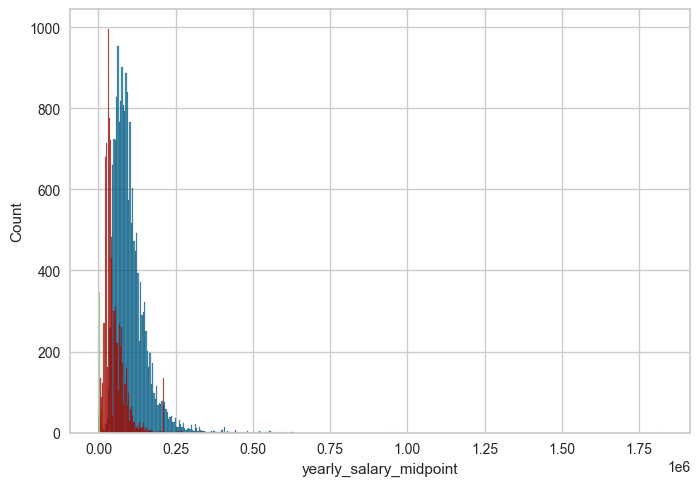

In [32]:
import seaborn as sns
sns.histplot(data=df[df["country"] == "US"], x="yearly_salary_midpoint")
sns.histplot(data=df[df["country"] == "IN"], x="yearly_salary_midpoint")
sns.histplot(data=df[df["country"] == "SG"], x="yearly_salary_midpoint")